# Preprocessinng

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("training_data.csv")
df.head()

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url
0,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,d5157f8bc52965390fa21ad5842a8502bc3eb8b0930f3f...,1550885210881,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...
1,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,61ef3869355b78e11011f39fc7ac8f8dfb209b3442a9d5...,1550885213307,4ed279f4f0deab6dfc80f4f7bf49d527fd894fa478a9ce...
2,20c458b802f6ea9374783bfc528b19421be977a6769785...,pageview,NaN,NaN,1550885213307,4ed279f4f0deab6dfc80f4f7bf49d527fd894fa478a9ce...
3,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,d5157f8bc52965390fa21ad5842a8502bc3eb8b0930f3f...,1550885215484,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...
4,20c458b802f6ea9374783bfc528b19421be977a6769785...,pageview,NaN,NaN,1550885215484,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...


## Pre-processing

pre-process the sessions (you can execute these tasks in the order you prefer, but make sure to specify which task is being solved in which block of code):
1. sessionise <font color='red'>(1pt)</font>
1. select sessions with at least one add-to-cart <font color='red'>(1pt)</font>
1. add class labels: treat purchase as the positive class <font color='red'>(1pt)</font>
1. cut purchase sessions to the last event before the first purchase <font color='red'>(1pt)</font>
1. remove sessions shorter than 5 and longer than 155 clicks <font color='red'>(1pt)</font>
1. symbolise actions <font color='red'>(1pt)</font>


In [3]:
# Sessionise:
# derive sessions from action by action dataset
# merge all the actions by session_id

df['product_action'] = df['product_action'].fillna('view')
df = df.groupby('session_id_hash')['product_action'].agg(list).reset_index()
df.head()

,session_id_hash,product_action
0,00000114e1075962f022114fcfc17f2d874e694ac5d201...,"[view, detail, add, view, view, view, view, vi..."
1,000009f36a40de1d557afc083dbb3fc03eef2473337bad...,"[view, view]"
2,00000e812c3076d18245710a31b348d3f23314b7d0dc90...,[view]
3,00001355930ff05e66ab30bccff221c33eba90e1517397...,"[view, detail]"
4,0000162d1dad0beb867c191ab2c8c7c06086cc57d9ebe2...,"[view, view, view, view, detail, view, detail,..."


In [4]:
##  labelization
df['purchase'] = np.where(df.product_action.map(set(['purchase']).issubset), 1, 0)
df.head()

,session_id_hash,product_action,purchase
0,00000114e1075962f022114fcfc17f2d874e694ac5d201...,"[view, detail, add, view, view, view, view, vi...",0
1,000009f36a40de1d557afc083dbb3fc03eef2473337bad...,"[view, view]",0
2,00000e812c3076d18245710a31b348d3f23314b7d0dc90...,[view],0
3,00001355930ff05e66ab30bccff221c33eba90e1517397...,"[view, detail]",0
4,0000162d1dad0beb867c191ab2c8c7c06086cc57d9ebe2...,"[view, view, view, view, detail, view, detail,...",0


In [5]:
### Cut actions before purchase if there is one
### keep the full sesssion if there is not
df['product_action'] = df['product_action'].map(lambda x: x[0:x.index('purchase')] if 'purchase' in x else x)

## select sessions with at least one add-to-cart
df = df[df.product_action.map(lambda x: "add" in x)]

### Filtered out outliers which > 155 or < 5.    

df["len"] = df["product_action"].map(len)

# removing very short and very long sessions
df.drop(df[df.len < 5].index, inplace=True)
df.drop(df[df.len > 155].index, inplace=True)

df.head()

,session_id_hash,product_action,purchase,len
0,00000114e1075962f022114fcfc17f2d874e694ac5d201...,"[view, detail, add, view, view, view, view, vi...",0,18
37,0000913afa22ba9c31efb992bcf6388b0bbfe28056bef3...,"[view, view, view, detail, view, view, detail,...",0,139
64,00010d84aca1294479304044207fd268f63228844779c6...,"[view, view, view, detail, view, view, view, v...",0,41
84,0001368d732951035a7ef7ef42b345a5c50b7d66966749...,"[view, detail, add, view, view, detail, add, v...",0,16
119,0001c180fb742f96ff388ba8f67a568e6fa66aed30d0d2...,"[view, view, view, view, detail, add, remove, ...",1,29


In [6]:
## Sanity check: the output should be True
df[df.product_action.map(lambda x: "add" not in x)].shape[0]

0

In [6]:
## symbolise actions

from collections import Counter

sessions = df['product_action'].to_list()
labels = df['purchase'].to_list()

counts = Counter([item for session in sessions for item in session])
symbol2idx = {symbol: idx for idx, symbol in enumerate(sorted(counts, key=counts.get, reverse=True), 1)}

df["session"]=df["product_action"].map(lambda session: [symbol2idx[s] for s in session])

df.head()

,session_id_hash,product_action,purchase,len,session
0,00000114e1075962f022114fcfc17f2d874e694ac5d201...,"[view, detail, add, view, view, view, view, vi...",0,18,"[1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, ..."
37,0000913afa22ba9c31efb992bcf6388b0bbfe28056bef3...,"[view, view, view, detail, view, view, detail,...",0,139,"[1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, ..."
64,00010d84aca1294479304044207fd268f63228844779c6...,"[view, view, view, detail, view, view, view, v...",0,41,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ..."
84,0001368d732951035a7ef7ef42b345a5c50b7d66966749...,"[view, detail, add, view, view, detail, add, v...",0,16,"[1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
119,0001c180fb742f96ff388ba8f67a568e6fa66aed30d0d2...,"[view, view, view, view, detail, add, remove, ...",1,29,"[1, 1, 1, 1, 2, 3, 4, 1, 2, 1, 1, 1, 4, 4, 4, ..."


In [7]:
## Check the symbolisation
symbol2idx

{'view': 1, 'detail': 2, 'add': 3, 'remove': 4}

## Oracle model

In [66]:
def oracle(X_train, y_train):
    '''
    This function return a oracle model based on the session and label.
    '''
    from collections import defaultdict

    d = defaultdict(lambda: defaultdict(int))
    for s, l in zip(X_train, y_train):
        d[str(tuple(s))][l] += 1
        
    model = {}
    for session in d.keys():
        n_buy, n_ws = 0, 0
        for label in d[session].keys():
            if label:
                n_buy += d[session][label]
            else:
                n_ws += d[session][label]
        model[session] = n_buy / (n_buy + n_ws)
        
    return model

def oracle_predict(model, X_test, y_test=None):
    '''
    1. Make prediction on X_test.
    2. For possibility >0.5 predict 1, else 0.
    3. reutrn prediction and F1 score
    '''
    from sklearn import metrics

    y_pred = []
    for x in X_test:
        pos = model.get(str(x), "#") ## For sessions that not in the model, we assign it to #, and then predict 0.
        y_pred.append(pos)
        
    ## count "#" first and substitute with 0
    missing_rate = y_pred.count("#")/len(y_pred)

    y_pred = [1 if y != "#" and y >= 0.5 else 0 for y in y_pred]
        
    if y_test is not None:
#         y_test = y_test.to_list()
        f1 = metrics.f1_score(y_test, y_pred)
        return(f1, missing_rate,y_pred)
    else:
        return y_pred

In [67]:
## Oracle model for 5 clicks
## Subset from the original df
from sklearn.model_selection import train_test_split

i = 5
data = df[["session", "purchase"]]
data.session = df.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
data.session = df.session.map(tuple)
data = data.dropna()
    
model = oracle(data.session, data.purchase)
f1, missing_rate, prediction = oracle_predict(model, data.session, data.purchase)
f1

/Users/moyang/.pyenv/versions/3.8.12/envs/default/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0.8457940701701135

In [68]:
# oracle model for 10 clicks
i = 10
data = df[["session", "purchase"]]
data.session = df.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
data.session = df.session.map(tuple)
data = data.dropna()
    
model = oracle(data.session, data.purchase)
f1, missing_rate, prediction = oracle_predict(model, data.session, data.purchase)
f1

/Users/moyang/.pyenv/versions/3.8.12/envs/default/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0.8457940701701135

In [69]:
# oracle model for 15 clicks
i = 15
data = df[["session", "purchase"]]
data.session = df.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
data.session = df.session.map(tuple)
data = data.dropna()
    
model = oracle(data.session, data.purchase)
f1, missing_rate, prediction = oracle_predict(model, data.session, data.purchase)
f1

/Users/moyang/.pyenv/versions/3.8.12/envs/default/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0.8457940701701135

## Hold Out

1. Subset data for n-click (n=5, 10, 15) models.
1. Do train/test split in for each subset.

In [8]:
### get subset for training
## make the prediction for 5, 10 and 15, and store the f1 it in a dict
## First split the train/test data
from sklearn.model_selection import train_test_split
from collections import defaultdict

data = defaultdict(lambda: defaultdict())

for i in [5, 10, 15]:
    
    ## Subset from the original df
    temp = df[["session", "purchase"]]
    temp.session = temp.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
    temp = temp.dropna()
    
    ## Split train and test
    X_train, X_test, y_train, y_test = train_test_split(temp["session"], temp["purchase"], test_size=0.2, random_state=123)
    data[f"{i}_clicks"]["X_train"] = X_train.to_numpy()
    data[f"{i}_clicks"]["X_test"] = X_test.to_numpy()
    data[f"{i}_clicks"]["y_train"] = y_train.to_numpy()
    data[f"{i}_clicks"]["y_test"] = y_test.to_numpy()

In [9]:
data_size = pd.DataFrame(data).applymap(len)
data_size

,5_clicks,10_clicks,15_clicks
X_train,86213,60709,44216
X_test,21554,15178,11054
y_train,86213,60709,44216
y_test,21554,15178,11054


## Naive Bayes Model

In [18]:
def ngram_featurizer(session, n=3):
    
    """takes in a list and an integer defining the size of ngrams.
     Returns the ngrams of desired size in the input string"""
    
    session = ['#']*(n-1) + session + ['+']*(n-1)
    ngrams = [tuple(session[i:i+n]) for i in range(len(session)-n+1)]
    
    return ngrams
    

def encode_sessions(sessions,n=3, mapping=None):
    
    """
    Takes in a list of lists, an integer indicating the character ngrams' size,
    and a dictionary mapping ngrams to numerical indices. If no dictionary is passed,
    one is created inside the function.
    The function outputs a 2d NumPy array with as many rows as there are strings in 
    the input list, and the mapping from ngrams to indices, representing the columns 
    of the NumPy array.
    """
    
    if not mapping:
        all_ngrams = set()
        for session in sessions:
            all_ngrams = all_ngrams.union(set(ngram_featurizer(session, n)))
    
        mapping = {ngram: i for i, ngram in enumerate(all_ngrams)}
    
    X = np.zeros((len(sessions), len(mapping)))
    for i, session in enumerate(sessions):
        for ngram in ngram_featurizer(session, n):
            try:
                X[i, mapping[ngram]] += 1
            except KeyError:
                pass
    
    return X, mapping

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

score = {}
for i in [5,10,15]:
    sessions_train = data[f"{i}_clicks"]["X_train"]
    sessions_eval = data[f"{i}_clicks"]["X_test"]
    labels_train = data[f"{i}_clicks"]["y_train"]
    labels_eval = data[f"{i}_clicks"]["y_test"]

    Xtrain, mapping = encode_sessions(sessions_train)
    Xtest, _ = encode_sessions(sessions_eval, mapping=mapping)

    NB = MultinomialNB(alpha=1, fit_prior=True)
    NB.fit(Xtrain,labels_train)
    bayes_predictions = NB.predict(Xtest)
    
    f1 = metrics.f1_score(labels_eval, bayes_predictions)
    
    score[f"F1_{i}-clicks"] = f1

In [34]:
score

{'F1_5-clicks': 0.34254807692307687,
 'F1_10-clicks': 0.3847316704459562,
 'F1_15-clicks': 0.3973732951675366}

## Advanced Model: XGBoost Classifier

### 5-clicks

In [171]:
i = '5_clicks'
X_train = data[i]['X_train']
y_train = data[i]['y_train']
X_test = data[i]['X_test']
y_test = data[i]['y_test']

In [173]:
i = '5_clicks'
X_train = data[i]['X_train']
y_train = data[i]['y_train']
X_test = data[i]['X_test']
y_test = data[i]['y_test']

## try xgboost on ngram = 2
import xgboost as xgb
xgb_cl = xgb.XGBClassifier()

X_train, mapping = encode_sessions(X_train, n=2)
X_test, _ = encode_sessions(X_test, n=2, mapping=mapping)

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

f1 = metrics.f1_score(y_test, preds)

f1

0.10063951531470886

In [174]:
i = '5_clicks'
X_train = data[i]['X_train']
y_train = data[i]['y_train']
X_test = data[i]['X_test']
y_test = data[i]['y_test']

## try n = 1 or 2

one_gram, maping_1 = encode_sessions(X_train,n=1, mapping=None)
two_gram, maping_2 = encode_sessions(X_train,n=2, mapping=None)

maping_2 = {key: value + len(maping_1) for key,value in maping_2.items()}
maping = {**maping_1, **maping_2}
X_train = np.concatenate((one_gram, two_gram), axis=1)

# featurize X_test
X = np.zeros((len(X_test), len(maping)))
for i, session in enumerate(X_test):
    for ngram in ngram_featurizer(session, 1) + ngram_featurizer(session, 2):
        try:
            X[i, maping[ngram]] += 1
        except KeyError:
            pass
X_test = X

In [175]:
# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

f1 = metrics.f1_score(y_test, preds)

f1

0.10869565217391304

In [97]:
## Tuning parameter 
from xgboost.sklearn import XGBClassifier


xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

# Fit
xgb1.fit(X_train, y_train)

# Predict
preds = xgb1.predict(X_test)

f1 = metrics.f1_score(y_test, preds)

f1

[17:24:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.11839530332681018

In [179]:
X_train

array([[10.,  4.,  1., ...,  0.,  0.,  1.],
       [15.,  1.,  1., ...,  0.,  1.,  1.],
       [10.,  1.,  1., ...,  0.,  0.,  1.],
       ...,
       [ 8.,  2.,  1., ...,  0.,  1.,  1.],
       [ 8.,  2.,  1., ...,  0.,  0.,  1.],
       [22.,  4.,  1., ...,  0.,  1.,  1.]])

In [180]:
# try the same model with downsampling
# 
from sklearn.utils import resample

i = '5_clicks'
X_train = data[i]['X_train']
y_train = data[i]['y_train']
X_test = data[i]['X_test']
y_test = data[i]['y_test']

temp = pd.DataFrame({"session": X_train, 'purchase': y_train})

class_0 = temp[temp.purchase == 0]
class_1 = temp[temp.purchase == 1]

class_0 = resample(class_0,
             replace=True,
             n_samples=len(class_1),
             random_state=123)


data_downsampled = pd.concat([class_0, class_1])

X_train = data_downsampled.session
y_train = data_downsampled.purchase

In [181]:
## Featurization: try n = 1 or 2
one_gram, maping_1 = encode_sessions(X_train,n=1, mapping=None)
two_gram, maping_2 = encode_sessions(X_train,n=2, mapping=None)

maping_2 = {key: value + len(maping_1) for key,value in maping_2.items()}
maping = {**maping_1, **maping_2}
X_train = np.concatenate((one_gram, two_gram), axis=1)

# featurize X_test
X = np.zeros((len(X_test), len(maping)))
for i, session in enumerate(X_test):
    for ngram in ngram_featurizer(session, 1) + ngram_featurizer(session, 2):
        try:
            X[i, maping[ngram]] += 1
        except KeyError:
            pass
X_test = X

In [182]:
## Tuning parameter 
from xgboost.sklearn import XGBClassifier


xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=123)

# Fit
xgb1.fit(X_train, y_train)

# Predict
preds = xgb1.predict(X_test)

f1 = metrics.f1_score(y_test, preds)

f1

0.42029263305859055

In [187]:
xgb2 = xgb.XGBClassifier(objective="binary:logistic", missing=0, seed = 123)

xgb2.fit(X_train,
         y_train,
         verbose=True,
         early_stopping_rounds = 10,
         eval_metric='aucpr',
         eval_set=[(X_test, y_test)])


[0]	validation_0-aucpr:0.35168
[1]	validation_0-aucpr:0.35755
[2]	validation_0-aucpr:0.36002
[3]	validation_0-aucpr:0.36005
[4]	validation_0-aucpr:0.36020
[5]	validation_0-aucpr:0.36265
[6]	validation_0-aucpr:0.36305
[7]	validation_0-aucpr:0.36330
[8]	validation_0-aucpr:0.36304
[9]	validation_0-aucpr:0.36339
[10]	validation_0-aucpr:0.36355
[11]	validation_0-aucpr:0.36430
[12]	validation_0-aucpr:0.36388
[13]	validation_0-aucpr:0.36354
[14]	validation_0-aucpr:0.36374
[15]	validation_0-aucpr:0.36345
[16]	validation_0-aucpr:0.36279
[17]	validation_0-aucpr:0.36246
[18]	validation_0-aucpr:0.36242
[19]	validation_0-aucpr:0.36261
[20]	validation_0-aucpr:0.36195
[21]	validation_0-aucpr:0.36138


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=0,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [189]:
# Predict
preds = xgb2.predict(X_test)

f1 = metrics.f1_score(y_test, preds)

f1

0.42922258799696134

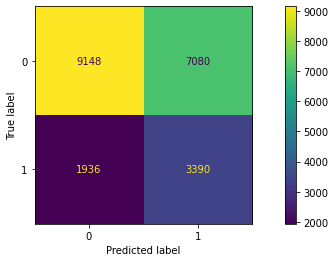

In [206]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(xgb2,
                      X_test,
                      y_test,
                      values_format='d',
                     )

### Grid Search

In [208]:
from sklearn.model_selection import GridSearchCV
## ROUND 1
# param_grid = {
#     'max_depth': [3,4,5],
#     'learning_rate': [0.1,0.01,0.05],
#     'gamma': [0,0.25,1.0],
#     'reg_lambda': [0,1.0, 10.0],
#     'scale_pos_weight': [1,3,5]
# }

# RESULT:
#        {'gamma': 0, 
#         'learning_rate': 0.05, 
#         'max_depth': 5, 
#         'reg_lambda': 10.0, 
#         'scale_pos_weight': 1}

## Round 2
param_grid = {
        'gamma': [0], 
        'learning_rate': [0.05], 
        'max_depth': [5, 6, 7],
        'reg_lambda': [9.0, 10.0, 11.0],
        'scale_pos_weight': [1]}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=123,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='f1',
    verbose = 0,
    n_jobs = 5,
    cv = 3
)

optimal_params.fit(X_train,
                   y_train,
                  early_stopping_rounds=10,
                  eval_metric='aucpr',
                  eval_set=[(X_test, y_test)],
                  verbose=False)
print(optimal_params.best_params_)

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'reg_lambda': 11.0, 'scale_pos_weight': 1}


### Building, Evaluating, Drawing, and Interpreting the Optimal XGBoost Model

In [202]:
optimal_params.best_params_

{'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 6,
 'reg_lambda': 11.0,
 'scale_pos_weight': 1}

In [209]:
preds = optimal_params.predict(X_test)

f1 = metrics.f1_score(y_test, preds)

f1

0.42948676461070484

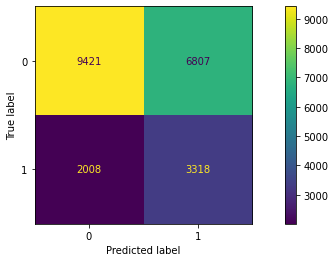

In [210]:
plot_confusion_matrix(optimal_params,
                      X_test,
                      y_test,
                      values_format='d',
                     )

In [212]:
tree = xgb.XGBClassifier(
    objective='binary:logistic',
    gamma=0,
    learn_rate=0.05,
    max_depth = 6,
    reg_lambda = 11.0,
    scale_pos_weight=1,
    subsample=0.9,
    colsample_bytree=0.5,
    n_estimator=1
)
tree.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='', learn_rate=0.05,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimator=1, n_estimators=100, n_jobs=4, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=11.0,
              scale_pos_weight=1, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

weight:  {'f0': 661.0, 'f1': 370.0, 'f2': 129.0, 'f3': 164.0, 'f4': 9.0, 'f5': 36.0, 'f6': 236.0, 'f7': 412.0, 'f8': 55.0, 'f9': 53.0, 'f10': 103.0, 'f11': 68.0, 'f12': 34.0, 'f13': 69.0, 'f14': 229.0, 'f15': 84.0, 'f16': 132.0, 'f17': 139.0, 'f18': 50.0, 'f19': 87.0, 'f20': 20.0, 'f21': 582.0, 'f22': 137.0, 'f24': 99.0, 'f25': 85.0, 'f26': 94.0, 'f27': 62.0}
gain:  {'f0': 1.4429550170898438, 'f1': 1.2198164463043213, 'f2': 1.7457644939422607, 'f3': 4.337860584259033, 'f4': 0.7056176066398621, 'f5': 1.3489816188812256, 'f6': 2.514075517654419, 'f7': 3.2335705757141113, 'f8': 1.4001697301864624, 'f9': 1.892753005027771, 'f10': 4.370830535888672, 'f11': 19.279909133911133, 'f12': 1.4241735935211182, 'f13': 1.510326623916626, 'f14': 1.3580574989318848, 'f15': 2.5010921955108643, 'f16': 1.7709850072860718, 'f17': 2.1710855960845947, 'f18': 5.953857898712158, 'f19': 1.370710849761963, 'f20': 1.3338161706924438, 'f21': 2.9449782371520996, 'f22': 1.6357736587524414, 'f24': 1.5896904468536377,

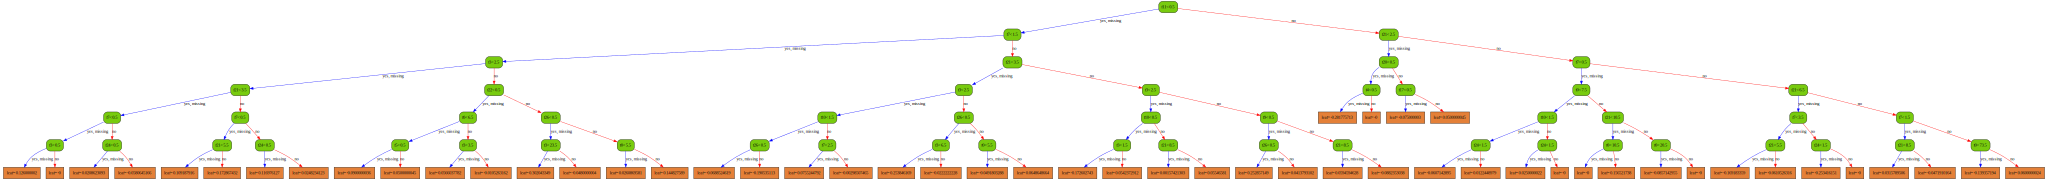

In [215]:
bst = tree.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'
              }
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(tree, num_trees = 0, size='5,5',
               condition_node_params=node_params,
               leaf_node_params=leaf_params)

## Markov Chain

In [79]:
# train Markov Chain
from collections import defaultdict

def get_ngram(session, i, n):
        
        """
        Takes in a list, an index and the ngram size n, and returns the history and current 
        token of the appropriate size: the current token is the one at the provided index, while the 
        history consists of the n-1 previous tokens. If the ngram size is 1, only the current token is returned.
        """
        
        if n == 1:
            return session[i]
        else:
            ngram = session[i-(n-1):i+1]
            history = tuple(ngram[:-1])
            target = ngram[-1]
            return (history, target)
        
                    
def update_counts(sessions, n):
        
    """
    Processes the input sessions given an ngram sizes and stores transition counts. 
    A dictionary of dictionary is created, where the first level key indicates the history, the second level 
    key indicates the current word, and the value indicates the history-current word co-occurrence count.
    If the ngram size is 1, then a simple dictionary mapping unigram to frequency count is created
    """
        
    counts = defaultdict(dict)
    for session in sessions:
        session = ['#']*(n-1) + session + ['+']
        for idx in range(n-1, len(session)):
            ngram = get_ngram(session, idx, n)
            if n == 1:
                counts[ngram] += 1
            else:
                # it's faster to try to do something and catch an exception than to use an if statement to 
                # check whether a condition is met beforehand. The if is checked everytime, the exception 
                # is only catched the first time, after that everything runs smoothly
                try:
                    counts[ngram[0]][ngram[1]] += 1
                except KeyError:
                    counts[ngram[0]][ngram[1]] = 1
        
    # first loop through the sentences in the corpus, than loop through each word in a sentence
    vocab = {event for session in sessions for event in session}
        
    return counts, vocab

In [78]:
def get_prior(labels):
    
    """
    Given a vector of binary labels (0 and 1), computes the probability of the positive class.
    """
    
    return np.mean(labels)

def get_posterior(prior, likelihood_one, likelihood_zero):
    
    """
    Given the prior of the positive class and the likelihood of an input under the language models trained
    on input from the positive and negative classes, returns the posterior probability of the positive class.
    """
    
    if 0 < likelihood_zero <= 1 and 0 < likelihood_one <= 1:
        return (prior * likelihood_one) / ((prior * likelihood_one) + ((1 - prior) * likelihood_zero))
    elif likelihood_zero <= 0 and likelihood_one <= 0:
        prior = np.log(prior) if 0 < prior <= 1 else prior
        normalize = np.logaddexp(prior + likelihood_one, 1 - prior + likelihood_zero)
        return np.exp(prior + likelihood_one - normalize)
    else:
        raise ValueError("One or both likelihood terms are higher than 1!")
    

def get_unigram_probability(ngram, counts, vocab_size, k=1):
        
    """
    When n==1, we get the unigram probability.
    Means that we get the probability of an event based on its prior event.
    In this function, we transfer the count into probability with smoothing constant of 1. 
    And do row normalization after.
    """
        
    tot = sum(list(counts.values())) + (vocab_size*k)
        
    try:
        ngram_count = counts[ngram] + k
    except KeyError:
        ngram_count = k
        
    return ngram_count/tot

def get_ngram_probability(history, target, counts, vocab_size, k=1):
        
    """
    When n>1, we get the ngram probability.
    Means that we get the probability of an event based on its prior n-1 event.
    In this function, we transfer the count into probability with smoothing constant of 1. 
    And do row normalization after.
    """
        
    try:
        ngram_tot = np.sum(list(counts[history].values())) + (vocab_size*k)
        try:
            transition_count = counts[history][target] + k
        except KeyError:
            transition_count = k
    except KeyError:
        transition_count = k
        ngram_tot = vocab_size*k
            
    return transition_count/ngram_tot 

def get_sequence_prob(session, counts, n, vocab_size, k=1):
        
    """
    Apply the Rule of Markov chain: 
    
    MULTIPLY the conditional probabily of each event in the sequence given its history with (n-1) length. 
    
    """
        
    probs = []
    for idx in range(n-1, len(session)):
        ngram = get_ngram(session, idx, n)
        if n == 1:
            probs.append(get_unigram_probability(ngram, counts, vocab_size))
        else:
            probs.append(get_ngram_probability(ngram[0], ngram[1], counts, vocab_size))

        return np.prod(probs)

In [77]:
def markov_train_predict(X_train, y_train, X_test, ngram = 3):
    '''
    1. take in the training data and split them into group of buy vs. non-buy;
    2. get the counts table for both group.
    3. Make prediction based on two count tables.
    '''
    
    ## Split the training data into two category: buy vs non_buy
    train_buy, train_ws = [], []
    for session, label in zip(X_train, y_train):
        if label == 1:
            train_buy.append(session)
        else:
            train_ws.append(session)
    
    ## calculate the count table
    buy_counts, buy_vocab = update_counts(train_buy, ngram)
    ws_counts, ws_vocab = update_counts(train_ws, ngram)
    
    ## get prior from traning data
    prior_buy = get_prior(y_train)
    
    ## Make prediction
    markov_predictions = []
    
    for session in X_test:
        likelihood_buy = get_sequence_prob(session, buy_counts, ngram, len(buy_vocab))
        likelihood_ws = get_sequence_prob(session, ws_counts, ngram, len(ws_vocab))

        markov_predictions.append(np.round(get_posterior(prior_buy, likelihood_buy, likelihood_ws)))
        
    return markov_predictions

### 5-clicks

In [72]:
i = '5_clicks'
X_train = data[i]['X_train']
y_train = data[i]['y_train']
X_test = data[i]['X_test']
y_test = data[i]['y_test']

In [80]:
for i in range(3,7):
    y_pred = markov_train_predict(X_train, y_train, X_test, ngram = i)

    # evaluate Markov Chain
    acc = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    print(f"For n={i}: acc={acc}, f1={f1}")

For n=3: acc=0.7528996937923356, f1=0.0
For n=4: acc=0.7528996937923356, f1=0.0
For n=5: acc=0.7528069035909808, f1=0.000375234521575985
For n=6: acc=0.7528532986916582, f1=0.00037530493525989863


### 10-clicks

In [81]:
i = '10_clicks'
X_train = data[i]['X_train']
y_train = data[i]['y_train']
X_test = data[i]['X_test']
y_test = data[i]['y_test']

In [83]:
for i in range(4,11):
    y_pred = markov_train_predict(X_train, y_train, X_test, ngram = i)

    # evaluate Markov Chain
    acc = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    print(f"For n={i}: acc={acc}, f1={f1}")

For n=4: acc=0.741929107919357, f1=0.0
For n=5: acc=0.7419949927526683, f1=0.0005104645227156713
For n=6: acc=0.741929107919357, f1=0.0
For n=7: acc=0.7414679140861774, f1=0.0
For n=8: acc=0.741929107919357, f1=0.0015294417537598777
For n=9: acc=0.7415996837528, f1=0.0030503304524656842
For n=10: acc=0.740677296086441, f1=0.005055611729019211


## 15-clicks

In [84]:
i = '10_clicks'
X_train = data[i]['X_train']
y_train = data[i]['y_train']
X_test = data[i]['X_test']
y_test = data[i]['y_test']

In [86]:
for i in range(4,12):
    y_pred = markov_train_predict(X_train, y_train, X_test, ngram = i)

    # evaluate Markov Chain
    acc = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    print(f"For n={i}: acc={acc}, f1={f1}")

For n=4: acc=0.741929107919357, f1=0.0
For n=5: acc=0.7419949927526683, f1=0.0005104645227156713
For n=6: acc=0.741929107919357, f1=0.0
For n=7: acc=0.7414679140861774, f1=0.0
For n=8: acc=0.741929107919357, f1=0.0015294417537598777
For n=9: acc=0.7415996837528, f1=0.0030503304524656842
For n=10: acc=0.740677296086441, f1=0.005055611729019211
For n=11: acc=0.7402819870865727, f1=0.009547738693467336
